<a href="https://colab.research.google.com/github/parmarsuraj99/keras-transformer-flex/blob/master/VirTex/CaptFormer_Exp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[VirTex - Learning Visual Representations from Textual Annotations](https://github.com/kdexd/virtex)

Karan Desai and Justin Johnson
University of Michigan

Preprint: [arxiv.org/abs/2006.06666](https://arxiv.org/abs/2006.06666)

### installling HuggingFace Transformers to use a pretrained tokenizer

In [ ]:
!pip install transformers

### importing required TF stuff and a backbone(ResNet50)

In [ ]:
import gc
import functools
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

In [ ]:
visual_backbone = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

##Transformer in keras

Heavily inspired by this TensorFlow Example [Transformer model for language understanding](https://www.tensorflow.org/tutorials/text/transformer)

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, query, key, value, mask):
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    print(f"Q:{query.shape}, K:{key.shape}, V:{value.shape}")
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
#Teting MHA

temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((20, 30, 512))  # (batch_size, encoder_sequence, d_model)
y2 = tf.random.uniform((20, 32, 512))  # (batch_size, encoder_sequence, d_model)
out = temp_mha(y2, y, y, mask=None)
out.shape

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])


**We'll use Decoder layer only**

**Note**
LayerNormalization is applied before Attention

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.self_attn = MultiHeadAttention(d_model = d_model, num_heads=num_heads)
    self.mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn1 = tf.keras.layers.Dense(dff, activation='relu')
    self.dropout = tf.keras.layers.Dropout(rate)
    self.ffn2 = tf.keras.layers.Dense(d_model)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, tgt, enc_output, training=True,
           look_ahead_mask=None, padding_mask=None):
      
    tgt = tf.transpose(tgt, [1, 0, 2])
    enc_output = tf.transpose(enc_output, [1, 0, 2])
      
    #Changed First layernorm then  masked attn
    tgt = self.layernorm1(tgt)
    print(f"TGT:{tgt.shape}")
    tgt2 = self.self_attn(tgt, tgt, tgt, mask=look_ahead_mask)
    #print(tgt2.shape)
    tgt = tgt + self.dropout1(tgt2)
    
    #print(enc_output.shape)
    #LayerNorm then decoder attn
    tgt = self.layernorm2(tgt)
    print(f"TGT:{tgt.shape}, ENC: {enc_output.shape}")
    tgt2 = self.mha(tgt, enc_output, enc_output, mask=None)
    print(f"target: {tgt.shape}, enc_op:{enc_output.shape}")
    tgt = tgt + self.dropout2(tgt2)
    
    #LayerNorm then FFN
    tgt = self.layernorm3(tgt)
    tgt2 = self.ffn2(self.dropout(self.ffn1(tgt),training))
    tgt = tgt + self.dropout3(tgt2)
    
    tgt = tf.transpose(tgt, [1, 0, 2])

    return tgt

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    attention_weights = {}

    for i in range(self.num_layers):
      x = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x


In [ ]:
%%time
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048)

tmp_memory = tf.random.uniform((60, 64, 512), dtype=tf.float32, minval=0, maxval=200)
tmp_tgt = tf.random.uniform((62, 64, 512), dtype=tf.float32, minval=0, maxval=200)

tgt_mask = tf.linalg.band_part(tf.ones([62, 62]), 0, -1)

output = sample_decoder(tmp_tgt, 
                        enc_output=tmp_memory, 
                        training=False,
                        look_ahead_mask=tgt_mask, 
                        padding_mask=None
                    )

output.shape

TGT:(64, 62, 512)
Q:(64, 8, 62, 64), K:(64, 8, 62, 64), V:(64, 8, 62, 64)
TGT:(64, 62, 512), ENC: (64, 60, 512)
Q:(64, 8, 62, 64), K:(64, 8, 60, 64), V:(64, 8, 60, 64)
target: (64, 62, 512), enc_op:(64, 60, 512)
TGT:(64, 62, 512)
Q:(64, 8, 62, 64), K:(64, 8, 62, 64), V:(64, 8, 62, 64)
TGT:(64, 62, 512), ENC: (64, 60, 512)
Q:(64, 8, 62, 64), K:(64, 8, 60, 64), V:(64, 8, 60, 64)
target: (64, 62, 512), enc_op:(64, 60, 512)
CPU times: user 2.76 s, sys: 33.1 ms, total: 2.8 s
Wall time: 1.57 s


In [ ]:
class WordAndPositionalEmbedding(tf.keras.layers.Layer):
    r"""
    A :class:`~torch.nn.Module` for learned word embeddings and position
    embeddings for input tokens. Each token is mapped to a fixed dimensional
    word embedding; and corresponding positional embedding based on its index.
    These are summed together followed by layer normalization and an optional
    dropout.
    Parameters
    ----------
    vocab_size: int
        Size of token vocabulary.
    hidden_size: int
        Size of token embedding vectors.
    max_caption_length: int, optional (default = 30)
        Maximum length of input captions; this is used to create a fixed
        positional embedding lookup table.
    dropout: float, optional (default = 0.1)
        Dropout probability for final dropout applied after layer normalization.
    padding_idx: int, optional (default = 0)
        Token index of ``[PAD]`` token, word embedding for these tokens will
        be a vector of zeroes (and not trainable).
    """

    def __init__(self, 
                 vocab_size: int, 
                 hidden_size:int, 
                 max_caption_length: int = 30, 
                 rate:float = 0.0,
                 padding_idx: int=0):
        super(WordAndPositionalEmbedding, self).__init__()

        self.vocab_size = vocab_size
        self.padding_idx = padding_idx

        self.words = L.Embedding(vocab_size, hidden_size, mask_zero=True)

        self.positions = L.Embedding(max_caption_length, hidden_size)
        self.layer_norm = L.LayerNormalization(
            epsilon=1e-8,
        )

        self.dropout = L.Dropout(rate = rate)


    def call(self, tokens):
        
        r"""
        Get combined word and positional embeddings for input tokens.
        Parameters
        ----------
        tokens: torch.Tensor
            A tensor of shape ``(batch_size, max_caption_length)`` containing
            a batch of caption tokens, with values in ``[0, vocab_size)``.
        Returns
        -------
        torch.Tensor
            A tensor of shape ``(batch_size, max_caption_length, hidden_size)``
            containing corresponding token embeddings.
        """
        print(tokens.shape)
        position_indices = self._create_position_indices(tokens)
        print(position_indices.shape)

        word_embeddings = self.words(tokens)
        positional_embeddings = self.positions(position_indices)


        embeddings = self.layer_norm(word_embeddings + positional_embeddings)
        embeddings = self.dropout(embeddings)


        token_mask = tf.expand_dims(tokens != self.padding_idx, -1)


        embeddings = embeddings * tf.cast(token_mask, dtype=embeddings.dtype)
        return embeddings

    def _create_position_indices(self, tokens):

        # Create position indices of the same size as token indices.
        batch_size, max_caption_length = tokens.shape
        positions = tf.range(
            max_caption_length, dtype=tokens.dtype
        )
        # shape: (batch_size, max_caption_length)
        positions = tf.broadcast_to(tf.expand_dims(positions, 0), [batch_size, max_caption_length])        
        return positions

In [ ]:
class TextualHead(tf.keras.layers.Layer):
    r"""
    Base class for all textual heads. All child classes can simply inherit
    from :class:`~torch.nn.Module`, however this is kept here for uniform
    type annotations.
    """
    def __init__(
        self,
        vocab_size: int,
        hidden_size: int,
    ):
        super(TextualHead, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size

    @property
    def textual_feature_size(self):
        
        r"""
        Size of the last dimension of output from forward pass; typically same
        as :attr:`hidden_size` for most modules. This property is used to add
        more modules on top of this.
        """
        return self.hidden_size


class LinearTextualHead(TextualHead):
    r"""
    Textual head containing a single linear layer projecting from textual
    feature size to output vocabulary size.
    """
    def __init__(
        self,
        vocab_size: int,
        hidden_size: int,
    ):
        super(LinearTextualHead, self).__init__(vocab_size, hidden_Size)
        self.output = L.Dense(vocab_size)

    def call(self,
             caption_tokens,
             caption_lengths,
             visual_features):
        
        output_logits = self.output(visual_features)
        return output_logits


In [ ]:
class TransformerTextualHead(TextualHead):
    def __init__(
        self,
        vocab_size: int,
        hidden_size:int,
        num_layers: int,
        attention_heads: int,
        feedforward_size: int,
        dropout: float = 0.1,
        norm_type:str="pre",
        padding_idx: int=0,
        max_caption_length: int = 30
    ):
        super().__init__(vocab_size, hidden_size)
        self.num_layers = num_layers
        self.attention_heads =attention_heads
        self.feedforward_size = feedforward_size
        self.dropout = dropout
        self.padding_idx = padding_idx

        self.embedding = WordAndPositionalEmbedding(
            self.vocab_size,
            self.textual_feature_size,
            max_caption_length = max_caption_length,
            rate = dropout,
        )
        LayerClass = (
            DecoderLayer
        )
        _layer = DecoderLayer(
            self.textual_feature_size,
            self.attention_heads,
            dff = self.feedforward_size,
            rate = dropout
        )
        
        self.encoder = Decoder(self.num_layers, self.textual_feature_size,
            self.attention_heads,
            dff = self.feedforward_size,
            rate = dropout)
        """
        self.encoder = DecoderLayer(
            self.textual_feature_size,
            self.attention_heads,
            dff = self.feedforward_size,
            rate = dropout)
        """

        self.outputL = L.Dense(vocab_size)
        #self.output.weight = self.embedding.words.weight

    def call(self,
             caption_tokens,
             caption_lengths,
             visual_features
             ):
        batch_size, max_caption_length = caption_tokens.shape
        print(max_caption_length)

        ones = tf.ones_like(caption_tokens)
        caption_mask = tf.expand_dims(caption_lengths, 1) < tf.cumsum(ones, 1)

        caption_embeddings = self.embedding(caption_tokens)

        unidirectional_mask = self._generate_future_mask(max_caption_length)

        print("cap_vis_mask:", caption_embeddings.shape, visual_features.shape, unidirectional_mask.shape)

        caption_embeddings = tf.transpose(caption_embeddings, [1, 0, 2])
        visual_features = tf.transpose(visual_features, [1, 0, 2])
        print(caption_embeddings.shape, visual_features.shape)

        textual_features = self.encoder(caption_embeddings,
                                        visual_features,
                                        look_ahead_mask=unidirectional_mask, 
                                        padding_mask=caption_mask)
        textual_features = tf.transpose(textual_features, [1, 0, 2])
        op = self.outputL(textual_features)

        return op

    def  _generate_future_mask(self, size:int):

        mask = tf.linalg.band_part(
            tf.ones([size, size]), 0, -1
        )
        return mask


## Forward Pass

In [ ]:
from transformers import GPT2TokenizerFast, BertTokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")

In [ ]:
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [ ]:
trf = TransformerTextualHead(vocab_size=50258, hidden_size=256, num_layers=6, attention_heads=8, feedforward_size=256, max_caption_length=50)

In [ ]:
enc = tokenizer.encode("hello Hi, How is it going", max_length=50,truncation=True, pad_to_max_length=True,  return_tensors="tf"); enc

<tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[31373, 15902,    11,  1374,   318,   340,  1016, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257]], dtype=int32)>

Prepating image using a visual backbone

In [ ]:
img = tf.random.uniform([1, 224,224,3]); img.shape
ps = visual_backbone(img); ps.shape

TensorShape([1, 7, 7, 2048])

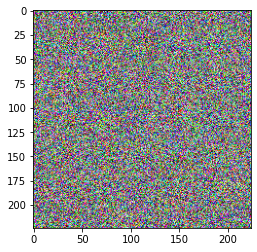

In [ ]:
plt.imshow(img[0].numpy())

In [ ]:
#(batch_size, height, width, n_channel) -> (batch_size, n_channel, height, width)
ps = tf.transpose(ps, [0, 3, 1, 2]); ps.shape

TensorShape([1, 2048, 7, 7])

In [ ]:
#(batch_size, n_channel, height, width) -> (batch_size, n_channel, height * width) 
rs = tf.reshape(ps, [ps.shape[0], ps.shape[1], -1])

#(batch_size, n_channel, height * width) -> (batch_size, height * width, n_channel)
rs = tf.transpose(rs, [0, 2, 1]); rs.shape

TensorShape([1, 49, 2048])

In [ ]:
#(batch_size, n_channel, height * width) -> (batch_size, height * width, visual features)
projected = L.Dense(256)(rs)

In [ ]:
projected.shape

TensorShape([1, 49, 256])

In [ ]:
tf.transpose(projected, [1, 0, 2]).shape

TensorShape([14336, 1, 256])

In [ ]:
caps = L.Dense(28996)(output)

In [ ]:
enc.shape, projected.shape

(TensorShape([1, 50]), TensorShape([1, 49, 256]))

In [ ]:
enc

<tf.Tensor: shape=(1, 50), dtype=int32, numpy=
array([[31373, 15902,    11,  1374,   318,   340,  1016, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
        50257, 50257, 50257, 50257, 50257]], dtype=int32)>

In [ ]:
%%time
caps = trf(enc, [50], projected)

In [ ]:
tf.argmax(caps, 2)

In [ ]:
tokenizer.batch_decode(tf.argmax(caps, 2))

['megamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamegamega']